In [267]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn

from transformers import BertTokenizer, BertModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

import pickle



In [268]:
os.getcwd()
os.chdir('C:/Users/frlan/Documents/NLP/dataset')

# change the path to C:\Users\Kyriakos\Desktop\MsC AI\NLP\NLP AirBNB Project\AirBnB_score_prediction\dataset
# os.chdir('C:\\Users\\Kyriakos\\Desktop\\MsC AI\\NLP\\NLP AirBNB Project\\AirBnB_score_prediction\\dataset')
# os.getcwd()


In [269]:
# import label_encoder to use it for the categorical features
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [270]:
# 'listings_comments.csv is the datset compined 

# reaf the datset from Google Drive G:\.shortcut-targets-by-id\1CZZx9Bpz7hB-BhPFsqAL3fRVyxM1XfwF\AirBnB_project
# data = pd.read_csv('G:\\.shortcut-targets-by-id\\1CZZx9Bpz7hB-BhPFsqAL3fRVyxM1XfwF\\AirBnB_project\\listings_comments.csv')

from dataloader import Dataloader
data = Dataloader()
data = data.getListings()



In [271]:
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

# Base Preperation

## Remove unnecessary columns

In [272]:
len(data.columns)

75

In [273]:
# Crate a list for removing unnecessary columns from the dataset
columns_to_remove = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source','picture_url', 'host_id',
       'host_url','host_name','host_location','host_thumbnail_url', 'host_picture_url','host_verifications','neighbourhood','neighbourhood_group_cleansed','latitude',
       'longitude','bathrooms','calendar_updated','has_availability','availability_30', 'availability_60', 'availability_90',
       'availability_365','calendar_last_scraped','review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value','instant_bookable',
       'calculated_host_listings_count','name','description']


In [274]:
# Remove the unnecessary columns from the dataset.
data.drop(columns_to_remove, axis=1, inplace=True)
len(data.columns)

39

## Check and replace nan values


In [275]:
def fill_nan(df, column):
    if(df[column].astype(str).str.isnumeric().all()==True):
        #Numeric values
        df[column].fillna(df[column].mean(), inplace=True)
    else:
        #string balue
        df[column].fillna('UNK', inplace=True)

    return df

for columnName in data.columns:
    data = fill_nan(data, columnName)

# Column processing

## Function that takes a column and returns an embeddings matrix

In [276]:
# Check the number of unique values in each column
data.nunique()


neighborhood_overview                           4039
host_since                                      2666
host_about                                      3302
host_response_time                                 5
host_response_rate                                50
host_acceptance_rate                              98
host_is_superhost                                  3
host_neighbourhood                                59
host_listings_count                               28
host_total_listings_count                         46
host_has_profile_pic                               2
host_identity_verified                             2
neighbourhood_cleansed                            22
property_type                                     59
room_type                                          4
accommodates                                      15
bathrooms_text                                    23
bedrooms                                          11
beds                                          

In [277]:
# load the model that is responsible for the text embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# create a device object
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
# move the model to the device
model.to(device)

# parallelize the model across multiple GPUs(if available)
model = nn.DataParallel(model)

underlying_model = model.module

Device: cuda


In [278]:
# function to get the embeddings for a column in a dataframe and return them as a numpy array
def get_embeddings(dataframe, column_name, batch_size=100):
    """
    Obtain sentence embeddings for a dataframe column using SentenceTransformer with batch processing.

    Args:
        dataframe (pandas.DataFrame): The dataframe containing the column to obtain embeddings for.
        column_name (str): The name of the column to obtain embeddings for.
        batch_size (int, optional): The size of each batch to process. Default is 100.

    Returns:
        numpy.ndarray: A numpy array containing the embeddings for the specified column.
    """

    # Obtain the embeddings for the specified column in batches
    num_batches = int(np.ceil(len(dataframe) / batch_size))
    embeddings = []
    for i in range(num_batches):
        start_index = i * batch_size
        end_index = min(start_index + batch_size, len(dataframe))
        batch_embeddings = model.encode(dataframe[column_name][start_index:end_index].tolist())
        embeddings.append(batch_embeddings)
    embeddings = np.concatenate(embeddings)

    return embeddings

In [279]:
data.columns
processedColumns = pd.DataFrame()


## Text Columns - word embedings

### neighborhood_overview

In [280]:
#Get the word encodings for the text in the column
neighborhood_overview_embeddings = underlying_model.encode(data.neighborhood_overview.values)


In [281]:
# Convert embeddings to a DataFrame with string column names
embedding_df = pd.DataFrame(neighborhood_overview_embeddings, columns=[f'neighborhood_overview_embeddings{i+1}' for i in range(neighborhood_overview_embeddings.shape[1])])

# Concatenate the numerical columns and the embeddings into a single DataFrame
processedColumns = pd.concat([processedColumns, embedding_df], axis=1)

### host_about

In [282]:
#Get the word encodings for the text in the column
host_about_embeddings = underlying_model.encode(data.host_about)

In [283]:
# Convert embeddings to a DataFrame with string column names
embedding_df = pd.DataFrame(host_about_embeddings, columns=[f'host_about_embeddings{i+1}' for i in range(host_about_embeddings.shape[1])])

# Concatenate the numerical columns and the embeddings into a single DataFrame
processedColumns = pd.concat([processedColumns, embedding_df], axis=1)

### bathroom_text

In [284]:
data.bathrooms_text

0              1.5 baths
1       1.5 shared baths
2         1 private bath
3              1.5 baths
4          1 shared bath
              ...       
6804      1 private bath
6805              1 bath
6806              1 bath
6807      1 private bath
6808           1.5 baths
Name: bathrooms_text, Length: 6809, dtype: object

In [285]:
import re

def extract_number(string):
    pattern = r'^(\d+(?:\.\d+)?)' # regular expression pattern to match the number at the start of the string
    match = re.match(pattern, string)
    if match:
        return float(match.group(1))
    else:
        return None
#Extract the number of bathrooms from the text example: 1.2 bathrooms > 1.2
numberOfBathrooms = data.bathrooms_text.apply(extract_number)
numberOfBathrooms

0       1.5
1       1.5
2       1.0
3       1.5
4       1.0
       ... 
6804    1.0
6805    1.0
6806    1.0
6807    1.0
6808    1.5
Name: bathrooms_text, Length: 6809, dtype: float64

In [286]:
processedColumns['bathrooms_text']=numberOfBathrooms
processedColumns.bathrooms_text

0       1.5
1       1.5
2       1.0
3       1.5
4       1.0
       ... 
6804    1.0
6805    1.0
6806    1.0
6807    1.0
6808    1.5
Name: bathrooms_text, Length: 6809, dtype: float64

### price

In [287]:
data.price

0       $100.00
1        $59.00
2       $106.00
3       $140.00
4        $75.00
         ...   
6804    $165.00
6805    $150.00
6806    $160.00
6807    $125.00
6808    $249.00
Name: price, Length: 6809, dtype: object

In [288]:
price_embeddings = underlying_model.encode(data.price)

In [289]:
# Convert embeddings to a DataFrame with string column names
embedding_df = pd.DataFrame(price_embeddings, columns=[f'price_embeddings{i+1}' for i in range(price_embeddings.shape[1])])

# Concatenate the numerical columns and the embeddings into a single DataFrame
processedColumns = pd.concat([processedColumns, embedding_df], axis=1)

## Categorical Columns - label encoding

### host_response_time

In [290]:
#Get the label encoding for the categorical column
encoding = le.fit_transform(data.host_response_time)


In [291]:
# Save the label encoding into the main pandas dataframe for later processing
processedColumns['host_response_time']=encoding
processedColumns

,neighborhood_overview_embeddings1,neighborhood_overview_embeddings2,neighborhood_overview_embeddings3,neighborhood_overview_embeddings4,neighborhood_overview_embeddings5,neighborhood_overview_embeddings6,neighborhood_overview_embeddings7,neighborhood_overview_embeddings8,neighborhood_overview_embeddings9,neighborhood_overview_embeddings10,...,price_embeddings376,price_embeddings377,price_embeddings378,price_embeddings379,price_embeddings380,price_embeddings381,price_embeddings382,price_embeddings383,price_embeddings384,host_response_time
0,-0.116372,0.097591,-0.060608,0.038863,0.014252,-0.047227,0.038234,-0.003749,-0.053559,-0.021652,...,0.017350,-0.004897,0.021727,-0.109080,0.020360,-0.028012,-0.097993,-0.091352,-0.076711,2
1,0.136016,-0.015675,0.040567,-0.057190,0.003332,0.013339,-0.048955,0.021005,-0.015902,-0.068776,...,0.007740,0.010420,-0.029209,-0.167799,-0.036253,0.032293,-0.116683,-0.117021,-0.062543,4
2,0.067852,0.060150,0.029182,0.027633,0.018493,0.014215,-0.025966,0.034286,-0.082199,-0.095101,...,-0.052159,0.013221,0.042182,-0.155596,0.062114,0.013426,-0.085340,-0.083137,-0.076989,4
3,0.113015,-0.039347,0.030979,-0.003132,0.019000,-0.008504,-0.004945,-0.068339,-0.038846,0.015379,...,-0.009861,0.004087,0.044521,-0.052210,-0.023781,0.005466,-0.131299,-0.124065,-0.063584,4
4,0.054659,-0.059907,0.037643,0.004035,0.079240,0.088770,0.037045,-0.014450,0.019367,-0.047079,...,-0.022121,-0.010562,0.047455,-0.121489,-0.014389,-0.012024,-0.170738,-0.076768,-0.051094,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6804,0.055526,-0.097399,0.024774,0.023912,0.040295,0.051588,0.001469,-0.003682,-0.122625,-0.062624,...,-0.041008,-0.037846,0.050282,-0.125588,-0.016783,-0.002898,-0.147602,-0.127343,-0.085092,2
6805,-0.116372,0.097591,-0.060608,0.038863,0.014252,-0.047227,0.038234,-0.003749,-0.053559,-0.021652,...,0.013831,0.002373,0.026096,-0.093082,-0.022921,-0.039951,-0.125145,-0.117809,-0.079352,2
6806,-0.116372,0.097591,-0.060608,0.038863,0.014252,-0.047227,0.038234,-0.003749,-0.053559,-0.021652,...,-0.007161,-0.027632,0.050558,-0.102924,0.003952,-0.021871,-0.136469,-0.128040,-0.052408,4
6807,0.118142,0.062713,-0.015865,0.026243,0.035154,0.018661,-0.076788,-0.077332,-0.051274,-0.009355,...,-0.047524,0.029830,0.043785,-0.110274,0.012278,-0.049344,-0.157149,-0.115694,-0.054802,4


### host_response_rate

In [292]:
encoding = le.fit_transform(data.host_response_rate)


In [293]:
processedColumns['host_response_rate']=encoding
processedColumns

,neighborhood_overview_embeddings1,neighborhood_overview_embeddings2,neighborhood_overview_embeddings3,neighborhood_overview_embeddings4,neighborhood_overview_embeddings5,neighborhood_overview_embeddings6,neighborhood_overview_embeddings7,neighborhood_overview_embeddings8,neighborhood_overview_embeddings9,neighborhood_overview_embeddings10,...,price_embeddings377,price_embeddings378,price_embeddings379,price_embeddings380,price_embeddings381,price_embeddings382,price_embeddings383,price_embeddings384,host_response_time,host_response_rate
0,-0.116372,0.097591,-0.060608,0.038863,0.014252,-0.047227,0.038234,-0.003749,-0.053559,-0.021652,...,-0.004897,0.021727,-0.109080,0.020360,-0.028012,-0.097993,-0.091352,-0.076711,2,36
1,0.136016,-0.015675,0.040567,-0.057190,0.003332,0.013339,-0.048955,0.021005,-0.015902,-0.068776,...,0.010420,-0.029209,-0.167799,-0.036253,0.032293,-0.116683,-0.117021,-0.062543,4,1
2,0.067852,0.060150,0.029182,0.027633,0.018493,0.014215,-0.025966,0.034286,-0.082199,-0.095101,...,0.013221,0.042182,-0.155596,0.062114,0.013426,-0.085340,-0.083137,-0.076989,4,1
3,0.113015,-0.039347,0.030979,-0.003132,0.019000,-0.008504,-0.004945,-0.068339,-0.038846,0.015379,...,0.004087,0.044521,-0.052210,-0.023781,0.005466,-0.131299,-0.124065,-0.063584,4,1
4,0.054659,-0.059907,0.037643,0.004035,0.079240,0.088770,0.037045,-0.014450,0.019367,-0.047079,...,-0.010562,0.047455,-0.121489,-0.014389,-0.012024,-0.170738,-0.076768,-0.051094,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6804,0.055526,-0.097399,0.024774,0.023912,0.040295,0.051588,0.001469,-0.003682,-0.122625,-0.062624,...,-0.037846,0.050282,-0.125588,-0.016783,-0.002898,-0.147602,-0.127343,-0.085092,2,29
6805,-0.116372,0.097591,-0.060608,0.038863,0.014252,-0.047227,0.038234,-0.003749,-0.053559,-0.021652,...,0.002373,0.026096,-0.093082,-0.022921,-0.039951,-0.125145,-0.117809,-0.079352,2,1
6806,-0.116372,0.097591,-0.060608,0.038863,0.014252,-0.047227,0.038234,-0.003749,-0.053559,-0.021652,...,-0.027632,0.050558,-0.102924,0.003952,-0.021871,-0.136469,-0.128040,-0.052408,4,1
6807,0.118142,0.062713,-0.015865,0.026243,0.035154,0.018661,-0.076788,-0.077332,-0.051274,-0.009355,...,0.029830,0.043785,-0.110274,0.012278,-0.049344,-0.157149,-0.115694,-0.054802,4,1


### host_acceptance_rate

In [294]:
encoding = le.fit_transform(data.host_acceptance_rate)

In [295]:
processedColumns['host_acceptance_rate']=encoding
processedColumns

,neighborhood_overview_embeddings1,neighborhood_overview_embeddings2,neighborhood_overview_embeddings3,neighborhood_overview_embeddings4,neighborhood_overview_embeddings5,neighborhood_overview_embeddings6,neighborhood_overview_embeddings7,neighborhood_overview_embeddings8,neighborhood_overview_embeddings9,neighborhood_overview_embeddings10,...,price_embeddings378,price_embeddings379,price_embeddings380,price_embeddings381,price_embeddings382,price_embeddings383,price_embeddings384,host_response_time,host_response_rate,host_acceptance_rate
0,-0.116372,0.097591,-0.060608,0.038863,0.014252,-0.047227,0.038234,-0.003749,-0.053559,-0.021652,...,0.021727,-0.109080,0.020360,-0.028012,-0.097993,-0.091352,-0.076711,2,36,93
1,0.136016,-0.015675,0.040567,-0.057190,0.003332,0.013339,-0.048955,0.021005,-0.015902,-0.068776,...,-0.029209,-0.167799,-0.036253,0.032293,-0.116683,-0.117021,-0.062543,4,1,2
2,0.067852,0.060150,0.029182,0.027633,0.018493,0.014215,-0.025966,0.034286,-0.082199,-0.095101,...,0.042182,-0.155596,0.062114,0.013426,-0.085340,-0.083137,-0.076989,4,1,95
3,0.113015,-0.039347,0.030979,-0.003132,0.019000,-0.008504,-0.004945,-0.068339,-0.038846,0.015379,...,0.044521,-0.052210,-0.023781,0.005466,-0.131299,-0.124065,-0.063584,4,1,2
4,0.054659,-0.059907,0.037643,0.004035,0.079240,0.088770,0.037045,-0.014450,0.019367,-0.047079,...,0.047455,-0.121489,-0.014389,-0.012024,-0.170738,-0.076768,-0.051094,3,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6804,0.055526,-0.097399,0.024774,0.023912,0.040295,0.051588,0.001469,-0.003682,-0.122625,-0.062624,...,0.050282,-0.125588,-0.016783,-0.002898,-0.147602,-0.127343,-0.085092,2,29,84
6805,-0.116372,0.097591,-0.060608,0.038863,0.014252,-0.047227,0.038234,-0.003749,-0.053559,-0.021652,...,0.026096,-0.093082,-0.022921,-0.039951,-0.125145,-0.117809,-0.079352,2,1,0
6806,-0.116372,0.097591,-0.060608,0.038863,0.014252,-0.047227,0.038234,-0.003749,-0.053559,-0.021652,...,0.050558,-0.102924,0.003952,-0.021871,-0.136469,-0.128040,-0.052408,4,1,79
6807,0.118142,0.062713,-0.015865,0.026243,0.035154,0.018661,-0.076788,-0.077332,-0.051274,-0.009355,...,0.043785,-0.110274,0.012278,-0.049344,-0.157149,-0.115694,-0.054802,4,1,96


### host_is_superhost

In [296]:
encoding = le.fit_transform(data.host_is_superhost)

In [297]:
processedColumns['host_is_superhost']=encoding
processedColumns.host_is_superhost

0       1
1       2
2       1
3       2
4       2
       ..
6804    2
6805    1
6806    1
6807    2
6808    1
Name: host_is_superhost, Length: 6809, dtype: int32

### host_neighbourhood

In [298]:
data.host_neighbourhood.value_counts()

UNK                                    3771
Oud-West                                555
Grachtengordel                          248
De Pijp                                 229
Jordaan                                 194
Oosterparkbuurt                         152
Bos en Lommer                           128
Indische Buurt                          118
Oost                                     88
Nieuwmarkt en Lastage                    83
Rivierenbuurt                            79
Hoofddorppleinbuurt                      72
Westelijke Eilanden                      70
De Wallen                                69
Weesperbuurt en Plantage                 66
Amsterdam Centrum                        61
Watergraafsmeer                          61
Oostelijke Eilanden en Kadijken          58
Zeeburg                                  56
Oud-Zuid                                 51
Frederik Hendrikbuurt                    51
Museumkwartier                           46
Spaarndammer en Zeeheldenbuurt  

In [299]:
vc = data.host_neighbourhood.value_counts()
single_neighborhoods = vc[vc == 1].index.tolist()

data.loc[data['host_neighbourhood'].isin(single_neighborhoods), 'host_neighbourhood'] = 'other'

single_neighborhoods

['Passy',
 'LB of Islington',
 'Grand Place',
 'Valdeacederas',
 'Belváros',
 'Stockwell',
 'Sant Antoni',
 'La Combe',
 'Nieuwendammerham',
 'La Sagrada Família',
 'Palermo Hollywood',
 'Cannaregio',
 'El Raval']

In [300]:
data.host_neighbourhood.value_counts().tail(5)

Tuindorp Nieuwendam                    7
Glòries - El Parc                      6
Buitenveldert-Oost                     4
Nieuwendammerdijk en Buiksloterdijk    4
Koreatown                              2
Name: host_neighbourhood, dtype: int64

In [301]:
encoding = le.fit_transform(data.host_neighbourhood)
processedColumns['host_neighbourhood']=encoding
processedColumns.host_neighbourhood

0       35
1       14
2       11
3       44
4        0
        ..
6804    22
6805    28
6806     7
6807    43
6808    31
Name: host_neighbourhood, Length: 6809, dtype: int32

### host_has_profile_pic

In [302]:
encoding = le.fit_transform(data.host_has_profile_pic)
processedColumns['host_has_profile_pic']=encoding
processedColumns.host_has_profile_pic

0       1
1       1
2       1
3       1
4       1
       ..
6804    1
6805    1
6806    1
6807    1
6808    1
Name: host_has_profile_pic, Length: 6809, dtype: int32

### host_identity_verified

In [303]:
encoding = le.fit_transform(data.host_identity_verified)
processedColumns['host_identity_verified']=encoding
processedColumns.host_identity_verified

0       1
1       1
2       1
3       1
4       1
       ..
6804    1
6805    1
6806    1
6807    1
6808    1
Name: host_identity_verified, Length: 6809, dtype: int32

### neighbourhood_cleansed

In [304]:
data.neighbourhood_cleansed.value_counts().tail(5)

De Aker - Nieuw Sloten    54
Bijlmer-Centrum           45
Gaasperdam - Driemond     44
Osdorp                    43
Bijlmer-Oost              25
Name: neighbourhood_cleansed, dtype: int64

In [305]:
encoding = le.fit_transform(data.neighbourhood_cleansed)
processedColumns['neighbourhood_cleansed']=encoding
processedColumns.neighbourhood_cleansed

0       20
1       14
2        4
3        5
4        5
        ..
6804     4
6805     7
6806     8
6807     4
6808     8
Name: neighbourhood_cleansed, Length: 6809, dtype: int32

### property_type

In [306]:
encoding = le.fit_transform(data.property_type)
processedColumns['property_type']=encoding
processedColumns.property_type

0       22
1       36
2       39
3       33
4       36
        ..
6804    22
6805    14
6806    14
6807    22
6808    14
Name: property_type, Length: 6809, dtype: int32

### room_type

In [307]:
encoding = le.fit_transform(data.room_type)
processedColumns['room_type']=encoding
processedColumns.room_type

0       2
1       2
2       2
3       2
4       2
       ..
6804    2
6805    0
6806    0
6807    2
6808    0
Name: room_type, Length: 6809, dtype: int32

## Numerical/date Columns - converted to regular numbers

### host_since

In [308]:
from datetime import date
from datetime import datetime

#Get the dates from the dataframe
datetest =data.host_since.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

#Convert dates to number
time = datetest.apply(lambda x: x.toordinal())

#Save the number to the data frame
processedColumns['host_since']= pd.Series(time.tolist())

#Print the change
processedColumns.host_since

0       734664
1       733309
2       733743
3       733854
4       733905
         ...  
6804    734825
6805    734829
6806    734528
6807    734830
6808    734832
Name: host_since, Length: 6809, dtype: int64

### host_listings_count

In [309]:
#Save the number that doesnt need to be changed into the processed columns dataframe for later processing
processedColumns['host_listings_count']= data.host_listings_count
processedColumns.host_listings_count

0       1
1       1
2       3
3       1
4       2
       ..
6804    1
6805    1
6806    1
6807    1
6808    1
Name: host_listings_count, Length: 6809, dtype: int64

### bedrooms

In [310]:
#Replace any occurances of "UNK" with number 0 since all values have to be int for PCA
withoutNa = data.bedrooms.replace("UNK",0)

#Make sure all values are type of float
processedColumns["bedrooms"]=withoutNa.astype(float)

#Vizualize
processedColumns.bedrooms

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
6804    1.0
6805    2.0
6806    2.0
6807    1.0
6808    2.0
Name: bedrooms, Length: 6809, dtype: float64

### beds

In [311]:
#Replace any occurances of "UNK" with number 0 since all values have to be int for PCA
withoutNa=data.beds.replace('UNK', 0)

#Make sure all values are of type float
processedColumns["beds"]=withoutNa.astype(float)

#Vizualize
processedColumns.beds

0       1.0
1       2.0
2       1.0
3       1.0
4       1.0
       ... 
6804    1.0
6805    2.0
6806    2.0
6807    1.0
6808    2.0
Name: beds, Length: 6809, dtype: float64

### host_total_listings_count

In [312]:

processedColumns['host_total_listings_count']= data.host_total_listings_count
processedColumns.host_total_listings_count

0       1
1       1
2       5
3       1
4       2
       ..
6804    1
6805    1
6806    2
6807    1
6808    5
Name: host_total_listings_count, Length: 6809, dtype: int64

### accommodates

In [313]:
processedColumns['accommodates']= data.accommodates
processedColumns.accommodates

0       2
1       2
2       2
3       2
4       2
       ..
6804    2
6805    4
6806    3
6807    2
6808    6
Name: accommodates, Length: 6809, dtype: int64

### minimum_nights

In [314]:
processedColumns['minimum_nights']= data.minimum_nights
processedColumns.minimum_nights

0       2
1       3
2       1
3       2
4       2
       ..
6804    1
6805    4
6806    3
6807    1
6808    4
Name: minimum_nights, Length: 6809, dtype: int64

### maximum_nights

In [315]:
processedColumns['maximum_nights']= data.maximum_nights
processedColumns.maximum_nights

0         30
1         28
2        365
3        356
4       1825
        ... 
6804    1125
6805      14
6806    1124
6807      30
6808      21
Name: maximum_nights, Length: 6809, dtype: int64

### minimum_minimum_nights

In [316]:
processedColumns['minimum_minimum_nights']= data.minimum_minimum_nights
processedColumns.minimum_minimum_nights

0       2
1       3
2       1
3       2
4       2
       ..
6804    1
6805    4
6806    3
6807    1
6808    3
Name: minimum_minimum_nights, Length: 6809, dtype: int64

### maximum_minimum_nights

In [317]:
processedColumns['maximum_minimum_nights']= data.maximum_minimum_nights
processedColumns.maximum_minimum_nights

0       2
1       3
2       1
3       2
4       2
       ..
6804    1
6805    4
6806    3
6807    1
6808    4
Name: maximum_minimum_nights, Length: 6809, dtype: int64

### minimum_maximum_nights

In [318]:
processedColumns['minimum_maximum_nights']= data.minimum_maximum_nights
processedColumns.minimum_maximum_nights

0         30
1       1125
2       1125
3       1125
4       1825
        ... 
6804    1125
6805      14
6806    1124
6807      30
6808       4
Name: minimum_maximum_nights, Length: 6809, dtype: int64

### maximum_maximum_nights

In [319]:
processedColumns['maximum_maximum_nights']= data.maximum_maximum_nights
processedColumns.maximum_maximum_nights

0         30
1       1125
2       1125
3       1125
4       1825
        ... 
6804    1125
6805      14
6806    1124
6807      30
6808      21
Name: maximum_maximum_nights, Length: 6809, dtype: int64

### minimum_nights_avg_ntm

In [320]:
processedColumns['minimum_nights_avg_ntm']= data.minimum_nights_avg_ntm
processedColumns.minimum_nights_avg_ntm

0       2.0
1       3.0
2       1.0
3       2.0
4       2.0
       ... 
6804    1.0
6805    4.0
6806    3.0
6807    1.0
6808    4.0
Name: minimum_nights_avg_ntm, Length: 6809, dtype: float64

### maximum_nights_avg_ntm

In [321]:
processedColumns['maximum_nights_avg_ntm']= data.maximum_nights_avg_ntm
processedColumns.maximum_nights_avg_ntm

0         30.0
1       1125.0
2       1125.0
3       1125.0
4       1825.0
         ...  
6804    1125.0
6805      14.0
6806    1124.0
6807      30.0
6808      20.8
Name: maximum_nights_avg_ntm, Length: 6809, dtype: float64

### number_of_reviews

In [322]:
processedColumns['number_of_reviews']= data.number_of_reviews
processedColumns.number_of_reviews

0        248
1        314
2        339
3        243
4        454
        ... 
6804     343
6805      18
6806      97
6807    1060
6808      17
Name: number_of_reviews, Length: 6809, dtype: int64

### number_of_reviews_l30d

In [323]:
processedColumns['number_of_reviews_l30d']= data.number_of_reviews_l30d
processedColumns.number_of_reviews_l30d

0        3
1        1
2        0
3        5
4        7
        ..
6804     0
6805     0
6806     0
6807    10
6808     0
Name: number_of_reviews_l30d, Length: 6809, dtype: int64

### first_review

In [324]:
data.first_review

0       2016-10-06
1       2009-03-30
2       2010-03-02
3       2012-01-09
4       2010-08-22
           ...    
6804    2013-02-19
6805    2013-01-04
6806    2013-05-14
6807    2012-11-29
6808    2013-02-26
Name: first_review, Length: 6809, dtype: object

In [325]:
timeData = data['first_review'].apply(lambda x: pd.Timestamp(x).toordinal() if x != 'UNK' else 0)
processedColumns['first_review']= pd.Series(timeData.tolist())
processedColumns.first_review

0       736243
1       733496
2       733833
3       734511
4       734006
         ...  
6804    734918
6805    734872
6806    735002
6807    734836
6808    734925
Name: first_review, Length: 6809, dtype: int64

### last_review


In [326]:
timeData = data['last_review'].apply(lambda x: pd.Timestamp(x).toordinal() if x != 'UNK' else 0)
processedColumns['last_review']= pd.Series(timeData.tolist())
processedColumns.last_review

0       738487
1       738465
2       737524
3       738486
4       738479
         ...  
6804    738449
6805    737473
6806    738445
6807    738492
6808    738411
Name: last_review, Length: 6809, dtype: int64

### calculated_host_listings_count_entire_homes

In [327]:
processedColumns['calculated_host_listings_count_entire_homes']= data.calculated_host_listings_count_entire_homes
processedColumns.calculated_host_listings_count_entire_homes

0       0
1       0
2       0
3       0
4       0
       ..
6804    0
6805    1
6806    1
6807    0
6808    1
Name: calculated_host_listings_count_entire_homes, Length: 6809, dtype: int64

### calculated_host_listings_count_private_rooms

In [328]:
processedColumns['calculated_host_listings_count_private_rooms']= data.calculated_host_listings_count_private_rooms
processedColumns.calculated_host_listings_count_private_rooms

0       1
1       1
2       2
3       1
4       2
       ..
6804    1
6805    0
6806    0
6807    1
6808    0
Name: calculated_host_listings_count_private_rooms, Length: 6809, dtype: int64

### calculated_host_listings_count_shared_rooms

In [329]:
processedColumns['calculated_host_listings_count_shared_rooms']= data.calculated_host_listings_count_shared_rooms
processedColumns.calculated_host_listings_count_shared_rooms

0       0
1       0
2       0
3       0
4       0
       ..
6804    0
6805    0
6806    0
6807    0
6808    0
Name: calculated_host_listings_count_shared_rooms, Length: 6809, dtype: int64

### reviews_per_month

In [330]:
withoutUNK = data.reviews_per_month.replace('UNK', 0)
processedColumns['reviews_per_month']= withoutUNK.astype(float)
processedColumns.reviews_per_month

0       3.30
1       1.88
2       2.18
3       1.83
4       3.03
        ... 
6804    2.88
6805    0.15
6806    0.83
6807    8.69
6808    0.14
Name: reviews_per_month, Length: 6809, dtype: float64

# PCA

In [344]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

processedColumns.dropna(inplace=True)

# Convert column names to strings
processedColumns.columns = processedColumns.columns.astype(str)

# instantiate a StandardScaler object
scaler = StandardScaler()

# scale the data
scaled_processedColumns = scaler.fit_transform(processedColumns)

# Create a PCA object with 2 components
pca = PCA(n_components=2)

# Fit and transform the data to 2 principal components
principal_components = pca.fit_transform(scaled_processedColumns)

# Convert principal components to a DataFrame with string column names
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Concatenate the principal components with the original data
result_df = pd.concat([principal_df, processedColumns], axis=1)

# Print the explained variance ratio of the 2 components
print(pca.explained_variance_ratio_)
print("___")
print(principal_df)

[0.12138795 0.08230594]
___
            PC1        PC2
0     19.300773   2.068514
1    -14.804175   1.656049
2     -9.193432  -2.352481
3     -6.833437   0.323179
4     -5.538446  -2.793872
...         ...        ...
6780 -12.570245   3.562348
6781   1.263750  19.345072
6782  11.662765   9.387087
6783 -14.703168   1.103666
6784   4.652638  15.729044

[6785 rows x 2 columns]


# Vizualization

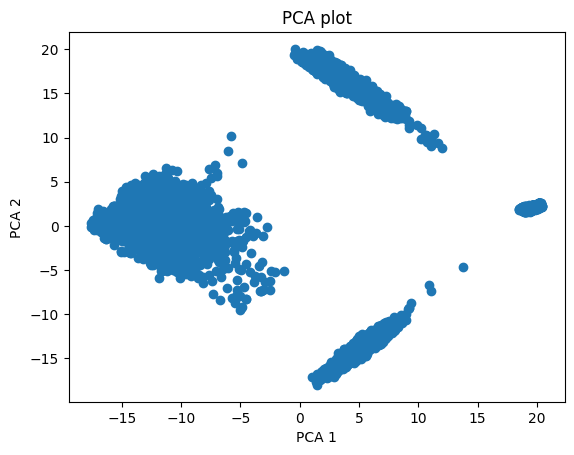

In [346]:

import matplotlib.pyplot as plt

# Plot PCA data
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA plot')
plt.show()